# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = np.array(train.label) # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

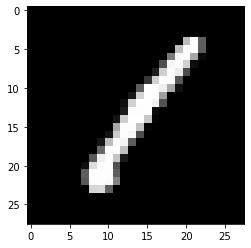

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray')
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [6]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10_batch32_data-aug_ensemble" # 設定に変更があった場合ここだけ変更
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

・バッチサイズは32のとき，アンサンブルモデルが最良のスコアを示した．  
・エポック数は10～30で実験を行ったが大きな変化は見られないため，10回を採用  
・データの水増しありで，精度が向上  
・各バリデーションモデルでアンサンブルを行ったとき，最も精度の向上が見られた．

In [7]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 32 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 # 学習率
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数，今回は使用しない
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1181 steps, validate on 4206 samples
Epoch 1/10
1180/1181 [============================>.] - ETA: 0s - loss: 4.5113 - acc: 0.9279- ETA: 1s - loss: 4.5233 
Epoch 00001: val_loss improved from inf to 3.93026, saving model to img_classifier_model_1_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 70s 59ms/step - loss: 4.5107 - acc: 0.9279 - val_loss: 3.9303 - val_acc: 0.9781
Epoch 2/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.7793 - acc: 0.9675
Epoch 00002: val_loss improved from 3.93026 to 3.59709, saving model to img_classifier_model_1_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 60s 51ms/step - loss: 3.7791 - acc: 0.9675 - val_loss: 3.5971 - val_acc: 0.9817
Epoch 3/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.5401 - acc: 0.9723- ET

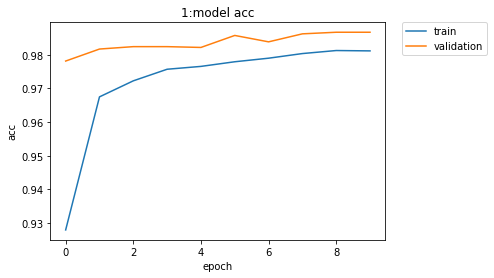

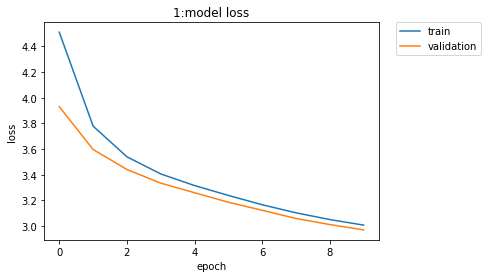

Done compiling best model.


1. Accuracy on validation data: 0.986686
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.99034   0.99515       414
           1    0.99786   0.99360   0.99573       469
           2    0.98568   0.98804   0.98686       418
           3    0.97743   0.99312   0.98521       436
           4    0.97362   0.99510   0.98424       408
           5    0.97409   0.98947   0.98172       380
           6    0.99512   0.98551   0.99029       414
           7    0.98869   0.99093   0.98981       441
           8    0.99000   0.97297   0.98141       407
           9    0.98301   0.96659   0.97473       419

   micro avg    0.98669   0.98669   0.98669      4206
   macro avg    0.98655   0.98657   0.98651      4206
weighted avg    0.98677   0.98669   0.98669      4206
 samples avg    0.98669   0.98669   0.98669      4206





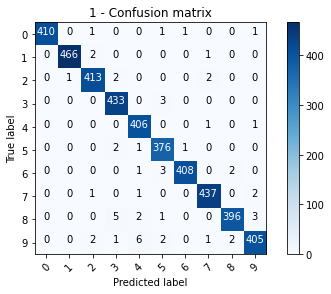

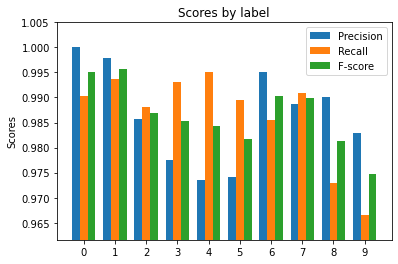

Iteration No. 2

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4204 samples
Epoch 1/10
1179/1181 [============================>.] - ETA: 0s - loss: 4.4095 - acc: 0.9332
Epoch 00001: val_loss improved from inf to 3.68722, saving model to img_classifier_model_2_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 69s 59ms/step - loss: 4.4083 - acc: 0.9333 - val_loss: 3.6872 - val_acc: 0.9774
Epoch 2/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.3949 - acc: 0.9755
Epoch 00002: val_loss improved from 3.68722 to 3.13441, saving model to img_classifier_model_2_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 60s 51ms/step - loss: 3.3948 - acc: 0.9755 - val_loss: 3.1344 - val_acc: 0.9784
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 2.9637 - acc: 0.9793
Epoch 00003: val_loss improved from 3.13441 to 2.79172, saving model to img_classifier_model_2_ResNet50_

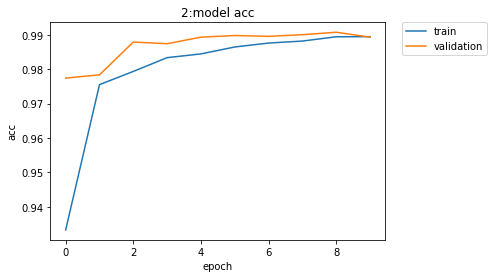

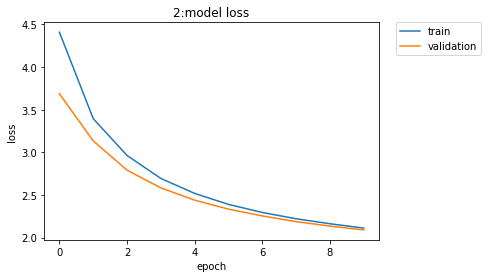

Done compiling best model.


2. Accuracy on validation data: 0.989296
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.99034   0.99515       414
           1    1.00000   0.98934   0.99464       469
           2    0.98345   0.99522   0.98930       418
           3    0.99085   0.99540   0.99312       435
           4    0.98305   0.99510   0.98904       408
           5    0.98408   0.97632   0.98018       380
           6    0.98798   0.99275   0.99036       414
           7    0.99314   0.98636   0.98974       440
           8    0.98529   0.98771   0.98650       407
           9    0.98329   0.98329   0.98329       419

   micro avg    0.98930   0.98930   0.98930      4204
   macro avg    0.98911   0.98918   0.98913      4204
weighted avg    0.98933   0.98930   0.98930      4204
 samples avg    0.98930   0.98930   0.98930      4204





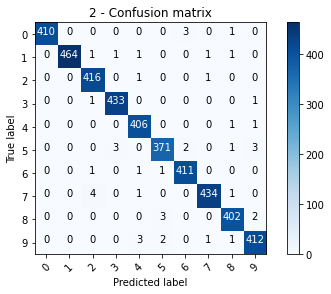

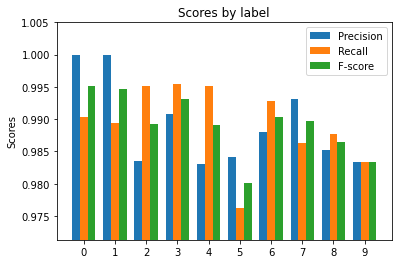

Iteration No. 3

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4202 samples
Epoch 1/10
1180/1181 [============================>.] - ETA: 0s - loss: 4.4765 - acc: 0.9318- ETA: 6s - loss: 4
Epoch 00001: val_loss improved from inf to 3.76483, saving model to img_classifier_model_3_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 68s 58ms/step - loss: 4.4760 - acc: 0.9318 - val_loss: 3.7648 - val_acc: 0.9776
Epoch 2/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.4938 - acc: 0.9725
Epoch 00002: val_loss improved from 3.76483 to 3.20645, saving model to img_classifier_model_3_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 60s 51ms/step - loss: 3.4935 - acc: 0.9725 - val_loss: 3.2065 - val_acc: 0.9864
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.0594 - acc: 0.9794
Epoch 00003: val_loss improved from 3.20645 to 2.89050, saving model to img_classifie

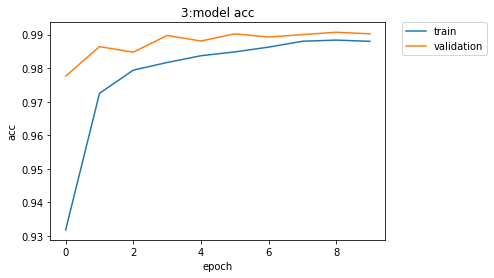

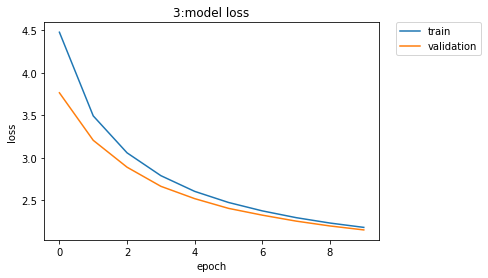

Done compiling best model.


3. Accuracy on validation data: 0.990243
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.98547   0.99268       413
           1    1.00000   0.99360   0.99679       469
           2    0.98109   0.99282   0.98692       418
           3    0.98630   0.99310   0.98969       435
           4    0.98054   0.99017   0.98533       407
           5    1.00000   0.98158   0.99070       380
           6    0.99275   0.99275   0.99275       414
           7    0.99545   0.99545   0.99545       440
           8    0.97590   0.99509   0.98540       407
           9    0.99036   0.98091   0.98561       419

   micro avg    0.99024   0.99024   0.99024      4202
   macro avg    0.99024   0.99010   0.99013      4202
weighted avg    0.99033   0.99024   0.99025      4202
 samples avg    0.99024   0.99024   0.99024      4202





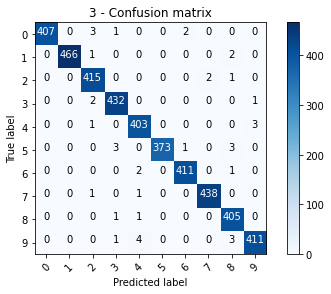

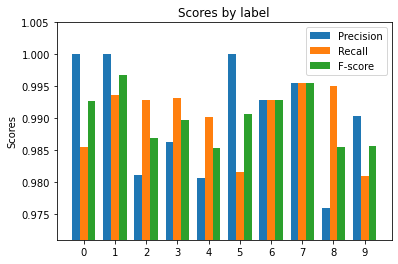

Iteration No. 4

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4201 samples
Epoch 1/10
1179/1181 [============================>.] - ETA: 0s - loss: 4.4605 - acc: 0.9334- ETA: 0s - loss: 4.4630 - acc: 0.9
Epoch 00001: val_loss improved from inf to 3.77810, saving model to img_classifier_model_4_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 70s 59ms/step - loss: 4.4593 - acc: 0.9335 - val_loss: 3.7781 - val_acc: 0.9736
Epoch 2/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.4797 - acc: 0.9726- ETA: 1s - loss: 
Epoch 00002: val_loss improved from 3.77810 to 3.21204, saving model to img_classifier_model_4_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 62s 53ms/step - loss: 3.4792 - acc: 0.9726 - val_loss: 3.2120 - val_acc: 0.9802
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.0476 - acc: 0.9791- ETA: 2s - los
Epoch 00003: val_loss improved from 

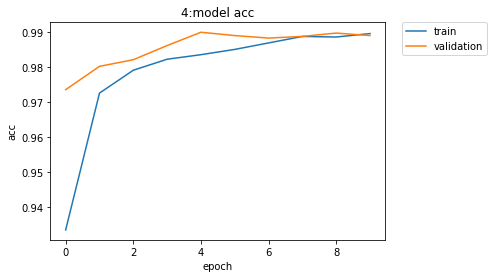

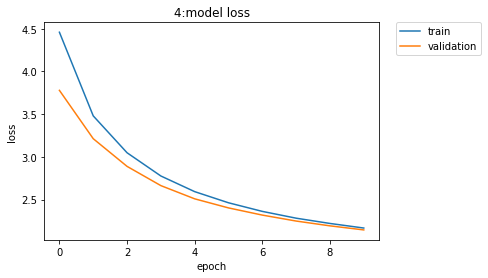

Done compiling best model.


4. Accuracy on validation data: 0.989050
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.98789   0.99391       413
           1    0.99140   0.98294   0.98715       469
           2    0.99279   0.98804   0.99041       418
           3    1.00000   0.99540   0.99770       435
           4    0.98533   0.99017   0.98775       407
           5    0.99206   0.98684   0.98945       380
           6    0.99038   0.99517   0.99277       414
           7    0.97968   0.98636   0.98301       440
           8    0.97108   0.99261   0.98173       406
           9    0.98804   0.98568   0.98686       419

   micro avg    0.98905   0.98905   0.98905      4201
   macro avg    0.98908   0.98911   0.98907      4201
weighted avg    0.98912   0.98905   0.98906      4201
 samples avg    0.98905   0.98905   0.98905      4201





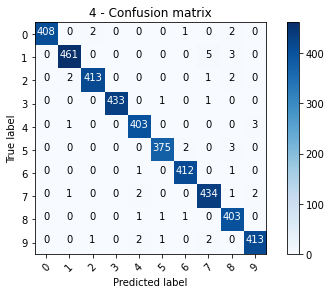

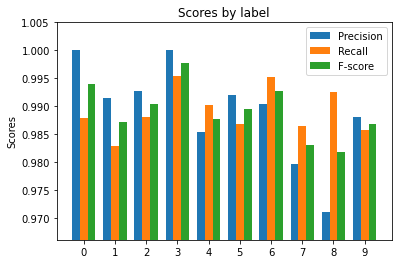

Iteration No. 5

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4200 samples
Epoch 1/10
1179/1181 [============================>.] - ETA: 0s - loss: 4.3697 - acc: 0.9339
Epoch 00001: val_loss improved from inf to 3.67151, saving model to img_classifier_model_5_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 69s 58ms/step - loss: 4.3689 - acc: 0.9339 - val_loss: 3.6715 - val_acc: 0.9705
Epoch 2/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.3600 - acc: 0.9735- ETA: 1s - loss: 3.3654 -
Epoch 00002: val_loss improved from 3.67151 to 3.08605, saving model to img_classifier_model_5_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 59s 50ms/step - loss: 3.3595 - acc: 0.9735 - val_loss: 3.0860 - val_acc: 0.9824
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 2.9289 - acc: 0.9804
Epoch 00003: val_loss improved from 3.08605 to 2.77341, saving model to img_cl

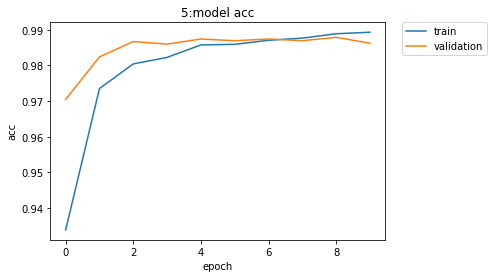

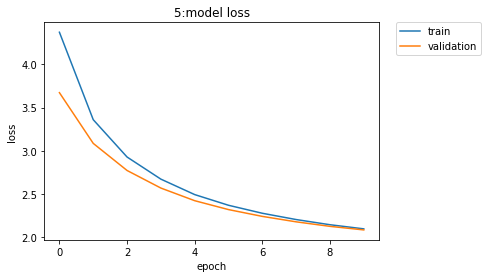

Done compiling best model.


5. Accuracy on validation data: 0.986190
Classification Report
              precision    recall  f1-score   support

           0    0.99756   0.99031   0.99392       413
           1    0.99782   0.97863   0.98813       468
           2    0.98565   0.98565   0.98565       418
           3    0.99078   0.98851   0.98964       435
           4    0.98289   0.98771   0.98529       407
           5    0.98438   0.99474   0.98953       380
           6    0.98551   0.98551   0.98551       414
           7    0.97763   0.99318   0.98534       440
           8    0.97555   0.98276   0.97914       406
           9    0.98317   0.97613   0.97964       419

   micro avg    0.98619   0.98619   0.98619      4200
   macro avg    0.98609   0.98631   0.98618      4200
weighted avg    0.98625   0.98619   0.98620      4200
 samples avg    0.98619   0.98619   0.98619      4200





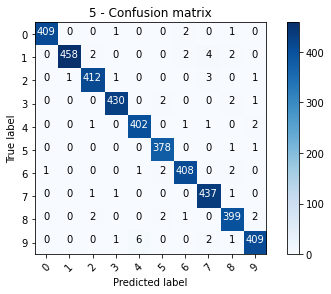

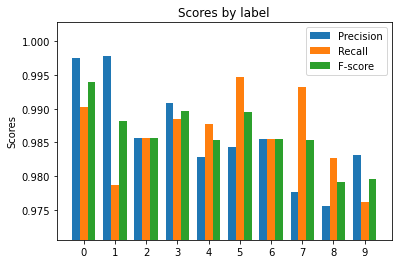

Iteration No. 6

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4199 samples
Epoch 1/10
1179/1181 [============================>.] - ETA: 0s - loss: 4.4181 - acc: 0.9333
Epoch 00001: val_loss improved from inf to 3.70037, saving model to img_classifier_model_6_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 69s 58ms/step - loss: 4.4174 - acc: 0.9333 - val_loss: 3.7004 - val_acc: 0.9809
Epoch 2/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.4227 - acc: 0.9730- ETA: 0s - loss: 3.4251 - acc: 0
Epoch 00002: val_loss improved from 3.70037 to 3.15157, saving model to img_classifier_model_6_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 59s 50ms/step - loss: 3.4225 - acc: 0.9730 - val_loss: 3.1516 - val_acc: 0.9843
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 2.9901 - acc: 0.9790
Epoch 00003: val_loss improved from 3.15157 to 2.82528, saving model to

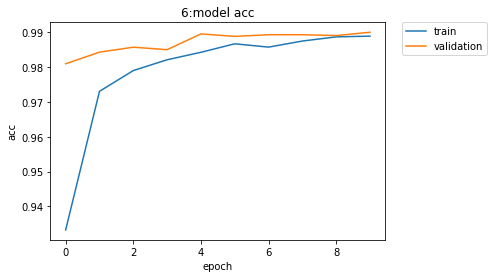

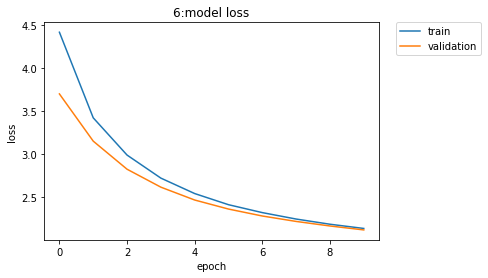

Done compiling best model.


6. Accuracy on validation data: 0.989998
Classification Report
              precision    recall  f1-score   support

           0    0.99756   0.99031   0.99392       413
           1    1.00000   0.99359   0.99678       468
           2    0.99045   0.99282   0.99164       418
           3    0.99085   0.99540   0.99312       435
           4    0.98780   0.99509   0.99143       407
           5    0.99469   0.98945   0.99206       379
           6    0.99272   0.98792   0.99031       414
           7    0.98864   0.98864   0.98864       440
           8    0.96867   0.99015   0.97929       406
           9    0.98792   0.97613   0.98199       419

   micro avg    0.99000   0.99000   0.99000      4199
   macro avg    0.98993   0.98995   0.98992      4199
weighted avg    0.99006   0.99000   0.99001      4199
 samples avg    0.99000   0.99000   0.99000      4199





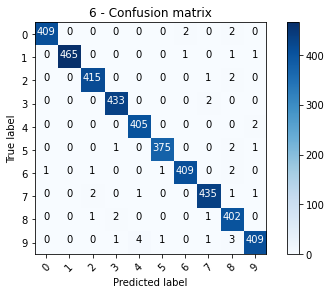

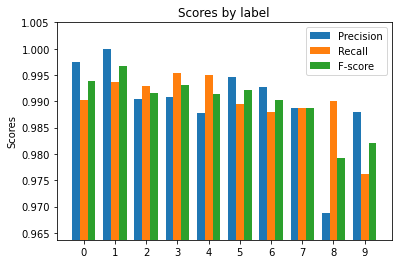

Iteration No. 7

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4199 samples
Epoch 1/10
1180/1181 [============================>.] - ETA: 0s - loss: 4.4151 - acc: 0.9338
Epoch 00001: val_loss improved from inf to 3.70480, saving model to img_classifier_model_7_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 68s 58ms/step - loss: 4.4145 - acc: 0.9339 - val_loss: 3.7048 - val_acc: 0.9757
Epoch 2/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.4126 - acc: 0.9734
Epoch 00002: val_loss improved from 3.70480 to 3.13593, saving model to img_classifier_model_7_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 59s 50ms/step - loss: 3.4120 - acc: 0.9734 - val_loss: 3.1359 - val_acc: 0.9848
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 2.9826 - acc: 0.9785
Epoch 00003: val_loss improved from 3.13593 to 2.81149, saving model to img_classifier_model_7_ResNet50_

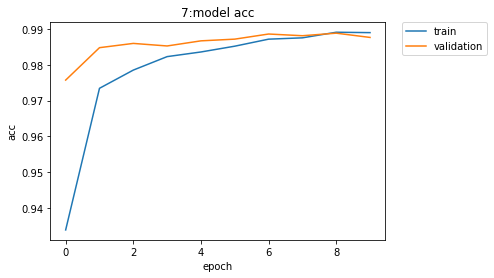

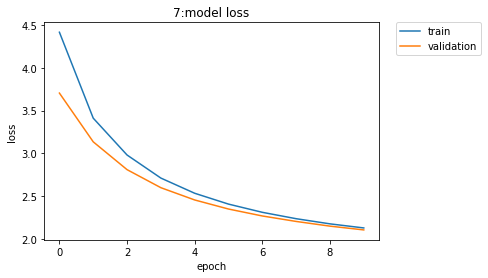

Done compiling best model.


7. Accuracy on validation data: 0.987616
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.98063   0.99022       413
           1    0.99359   0.99359   0.99359       468
           2    0.98317   0.97847   0.98082       418
           3    0.98843   0.98161   0.98501       435
           4    0.98058   0.99263   0.98657       407
           5    0.97680   1.00000   0.98827       379
           6    0.99272   0.98792   0.99031       414
           7    0.98636   0.98636   0.98636       440
           8    0.98775   0.99261   0.99017       406
           9    0.98565   0.98329   0.98447       419

   micro avg    0.98762   0.98762   0.98762      4199
   macro avg    0.98750   0.98771   0.98758      4199
weighted avg    0.98767   0.98762   0.98762      4199
 samples avg    0.98762   0.98762   0.98762      4199





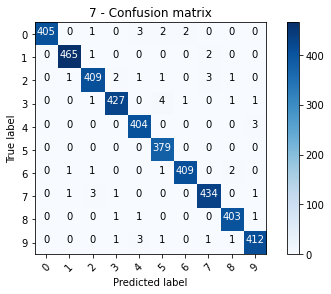

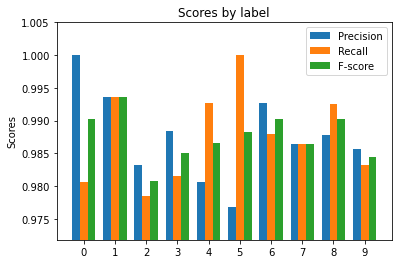

Iteration No. 8

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4197 samples
Epoch 1/10
1180/1181 [============================>.] - ETA: 0s - loss: 4.4038 - acc: 0.9363
Epoch 00001: val_loss improved from inf to 3.70111, saving model to img_classifier_model_8_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 69s 58ms/step - loss: 4.4032 - acc: 0.9364 - val_loss: 3.7011 - val_acc: 0.9745
Epoch 2/10
1180/1181 [============================>.] - ETA: 0s - loss: 3.4116 - acc: 0.9736
Epoch 00002: val_loss improved from 3.70111 to 3.13382, saving model to img_classifier_model_8_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 59s 50ms/step - loss: 3.4114 - acc: 0.9736 - val_loss: 3.1338 - val_acc: 0.9855
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 2.9785 - acc: 0.9799
Epoch 00003: val_loss improved from 3.13382 to 2.81460, saving model to img_classifier_model_8_ResNet50_

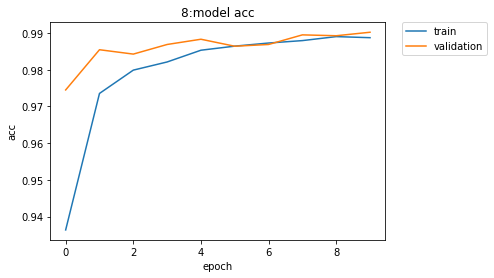

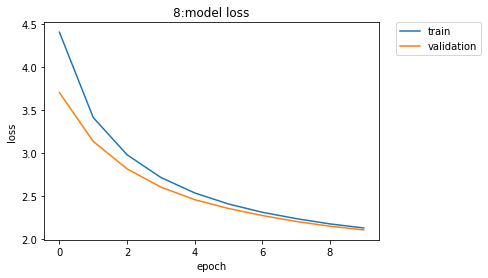

Done compiling best model.


8. Accuracy on validation data: 0.990231
Classification Report
              precision    recall  f1-score   support

           0    0.99275   0.99516   0.99395       413
           1    0.99787   1.00000   0.99893       468
           2    0.99038   0.98801   0.98920       417
           3    0.99539   0.99310   0.99425       435
           4    0.98780   0.99509   0.99143       407
           5    0.98433   0.99472   0.98950       379
           6    0.99510   0.98305   0.98904       413
           7    0.98864   0.98864   0.98864       440
           8    0.98044   0.98768   0.98405       406
           9    0.98792   0.97613   0.98199       419

   micro avg    0.99023   0.99023   0.99023      4197
   macro avg    0.99006   0.99016   0.99010      4197
weighted avg    0.99025   0.99023   0.99023      4197
 samples avg    0.99023   0.99023   0.99023      4197





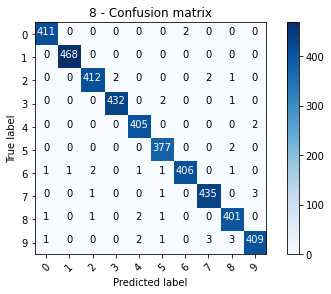

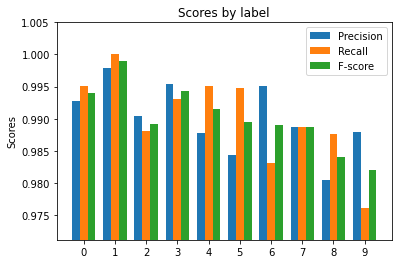

Iteration No. 9

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4196 samples
Epoch 1/10
1180/1181 [============================>.] - ETA: 0s - loss: 4.4013 - acc: 0.9321
Epoch 00001: val_loss improved from inf to 3.68970, saving model to img_classifier_model_9_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 68s 58ms/step - loss: 4.4007 - acc: 0.9321 - val_loss: 3.6897 - val_acc: 0.9781
Epoch 2/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.4028 - acc: 0.9731
Epoch 00002: val_loss improved from 3.68970 to 3.12746, saving model to img_classifier_model_9_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 59s 50ms/step - loss: 3.4024 - acc: 0.9731 - val_loss: 3.1275 - val_acc: 0.9828
Epoch 3/10
1180/1181 [============================>.] - ETA: 0s - loss: 2.9794 - acc: 0.9778
Epoch 00003: val_loss improved from 3.12746 to 2.81010, saving model to img_classifier_model_9_ResNet50_

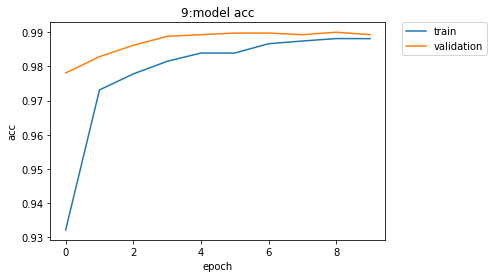

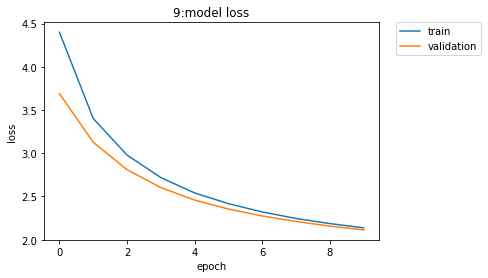

Done compiling best model.


9. Accuracy on validation data: 0.989276
Classification Report
              precision    recall  f1-score   support

           0    0.99275   0.99516   0.99395       413
           1    0.99356   0.98932   0.99143       468
           2    0.97406   0.99041   0.98216       417
           3    0.99769   0.99080   0.99423       435
           4    0.98068   0.99754   0.98904       407
           5    0.99211   0.99472   0.99341       379
           6    0.99756   0.99031   0.99392       413
           7    0.99091   0.99091   0.99091       440
           8    0.98272   0.98030   0.98150       406
           9    0.99027   0.97368   0.98191       418

   micro avg    0.98928   0.98928   0.98928      4196
   macro avg    0.98923   0.98932   0.98925      4196
weighted avg    0.98933   0.98928   0.98928      4196
 samples avg    0.98928   0.98928   0.98928      4196





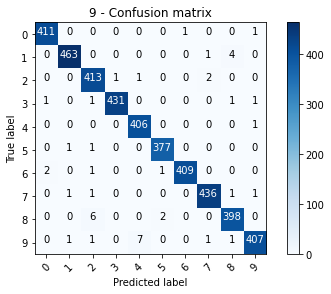

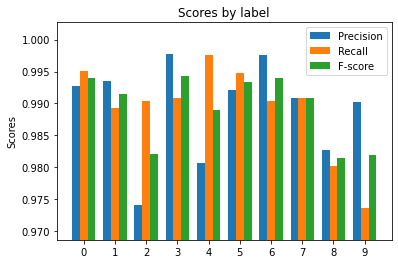

Iteration No. 10

  ...
    to  
  ['...']
Train for 1181 steps, validate on 4196 samples
Epoch 1/10
1179/1181 [============================>.] - ETA: 0s - loss: 4.4784 - acc: 0.9330
Epoch 00001: val_loss improved from inf to 3.78945, saving model to img_classifier_model_10_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 68s 58ms/step - loss: 4.4772 - acc: 0.9331 - val_loss: 3.7895 - val_acc: 0.9762
Epoch 2/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.5069 - acc: 0.9715- 
Epoch 00002: val_loss improved from 3.78945 to 3.23221, saving model to img_classifier_model_10_ResNet50_epoch10_batch32_data-aug_ensemble.h5
1181/1181 [==============================] - 59s 50ms/step - loss: 3.5064 - acc: 0.9716 - val_loss: 3.2322 - val_acc: 0.9845
Epoch 3/10
1179/1181 [============================>.] - ETA: 0s - loss: 3.0752 - acc: 0.9793
Epoch 00003: val_loss improved from 3.23221 to 2.91136, saving model to img_classifier_model_10_Res

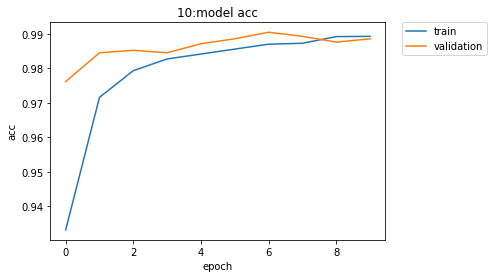

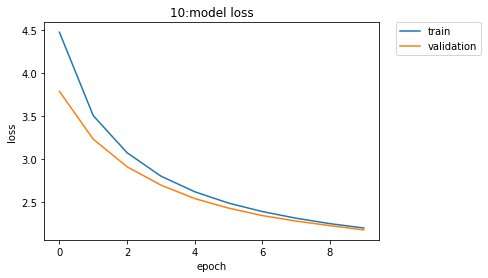

Done compiling best model.


10. Accuracy on validation data: 0.988561
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.99031   0.99513       413
           1    0.99785   0.99145   0.99464       468
           2    0.99048   0.99760   0.99403       417
           3    0.98618   0.98391   0.98504       435
           4    0.98768   0.98526   0.98647       407
           5    0.98684   0.98945   0.98814       379
           6    0.98804   1.00000   0.99398       413
           7    0.98409   0.98409   0.98409       440
           8    0.98756   0.97783   0.98267       406
           9    0.97630   0.98565   0.98095       418

   micro avg    0.98856   0.98856   0.98856      4196
   macro avg    0.98850   0.98856   0.98852      4196
weighted avg    0.98859   0.98856   0.98856      4196
 samples avg    0.98856   0.98856   0.98856      4196





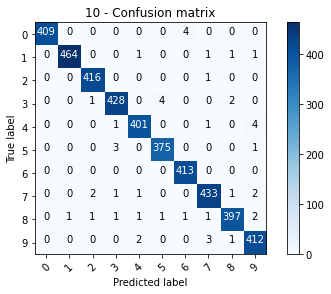

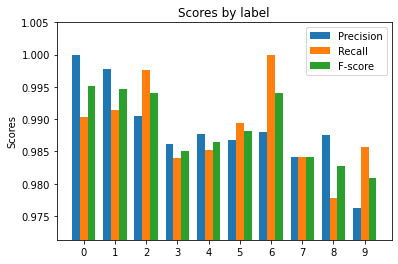

In [8]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    # データの水増しなし
    if not "data-aug" in model_name:
        history = ResNetModel.fit(X_train, 
                                  Y_train, 
                                  batch_size=batch_size, 
                                  epochs=n_epoch,
                                  verbose=1,
                                  shuffle=True,
                                  validation_data=(X_val, Y_val),
                                  callbacks=callbacks_list)
    # データの水増しあり
    else:
        datagen = ImageDataGenerator(
                    rotation_range=10,  # -10° ~ 10°の範囲でランダムに回転
                    zoom_range = 0.1, # 0.9 ~ 1.1 倍の範囲でランダムに拡大縮小
                    width_shift_range=0.1,  # -0.1*width ~ 0.1*widthの範囲でランダムに左右平行移動
                    height_shift_range=0.1)  # -0.1*height ~ 0.1*heightの範囲でランダムに上下平行移動
        
        datagen.fit(X_train)
        
        history = ResNetModel.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                      epochs = n_epoch, validation_data = (X_val, Y_val),
                                      verbose = 1, shuffle=True, steps_per_epoch=X_train.shape[0] // batch_size,
                                      callbacks=callbacks_list)
        del datagen
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各ラベルの精度に関してグラフ化
    def plot_scores(precision, recall, fscore, title):
        x = np.arange(len(class_names)) * 2 # ラベルの位置
        width = 0.5 # バーの横幅

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label="Precision")
        rects2 = ax.bar(x, recall, width, label="Recall")
        rects3 = ax.bar(x + width, fscore, width, label="F-score")
        ylim_min = np.min([precision, recall, fscore]) - 0.005
        ylim_max = np.max([precision, recall, fscore]) + 0.005

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by label')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names)
        ax.set_ylim(ylim_min, ylim_max)
        ax.legend()

        plt.savefig(csv_dir + "/" + title)
        plt.show()
    
    plot_scores(precision_list[i], recall_list[i], fscore_list[i], title = str(i+1)+ " - Score.png")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
if "ensemble" in model_name:
    for i in glob.glob("*model*"+model_name+"*"+"h5"):
        shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.988714
Classification Report
              precision    recall  f1-score   support

           0    0.99805   0.98959   0.99380      4132
           1    0.99699   0.99061   0.99379      4684
           2    0.98569   0.98971   0.98770      4177
           3    0.99035   0.99104   0.99070      4351
           4    0.98297   0.99239   0.98766      4072
           5    0.98686   0.98972   0.98829      3795
           6    0.99177   0.99009   0.99093      4137
           7    0.98730   0.98909   0.98820      4401
           8    0.98042   0.98597   0.98319      4063
           9    0.98557   0.97875   0.98215      4188

   micro avg    0.98871   0.98871   0.98871     42000
   macro avg    0.98860   0.98870   0.98864     42000
weighted avg    0.98874   0.98871   0.98872     42000
 samples avg    0.98871   0.98871   0.98871     42000





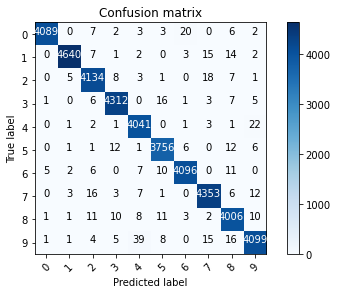

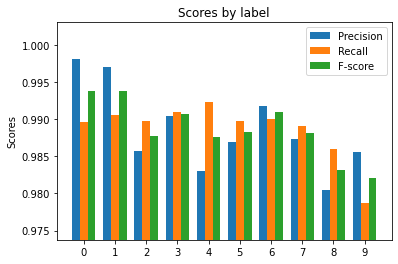

In [9]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
plot_scores(avg[4:35:3], avg[5:35:3], avg[6:35:3], title = "Score.png")

### 4.2.3 Error data results

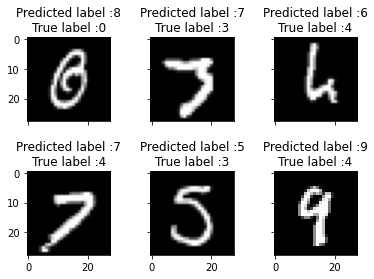

In [10]:
# 間違って推測したラベルの予測値と正しいラベルの予測値の差が大きいデータを上位6枚表示
predict_label_num = np.argmax(predict, axis=1) # 予測されたクラス名
errors = (predict_label_num - label_num != 0) # 間違ったデータはTrue

pred_classes_errors = predict_label_num[errors] # エラーデータの予測されたクラス名を抽出
pred_errors = predict[errors] # エラーデータの各クラスの予測値
true_errors = label_num[errors] # エラーデータの正しいクラス名
val_errors = train[errors] # エラーデータ（画像）

# 予測ラベルと正解ラベルを表記して，エラーデータを表示する関数
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    # 余白を設定
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.savefig(csv_dir + "/" + "Error.png")

# エラーデータが間違って予測されたクラスの予測値を抽出
pred_errors_prob = np.max(pred_errors,axis = 1)

# エラーデータの正しいクラスの予測値を抽出
true_prob_errors = np.diagonal(np.take(pred_errors, true_errors, axis=1))

# 予測されたクラスと正しいクラスの予測値の差
delta_pred_true_errors = pred_errors_prob - true_prob_errors

# delta_pred_true_errorsを小さい順にソートした時のインデックスを抽出
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 正解ラベルとの予測値の差が大きいデータのインデックスを上位6個抽出
most_important_errors = sorted_dela_errors[-6:]

# 表示
display_errors(most_important_errors, val_errors, pred_classes_errors, true_errors)

# 5. All data training and test

## 5.1 Training

  ...
    to  
  ['...']
Train for 1312 steps
Epoch 1/10
1312/1312 [==============================] - 70s 54ms/step - loss: 4.3659 - acc: 0.9380
Epoch 2/10
1312/1312 [==============================] - 63s 48ms/step - loss: 3.3606 - acc: 0.9752
Epoch 3/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.9261 - acc: 0.9806
Epoch 4/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.6635 - acc: 0.9836
Epoch 5/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.4911 - acc: 0.9853
Epoch 6/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.3701 - acc: 0.9859 4s - l - ETA: 2s - loss
Epoch 7/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.2783 - acc: 0.9879
Epoch 8/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.2062 - acc: 0.9884
Epoch 9/10
1312/1312 [==============================] - 63s 48ms/step - loss: 2.1504 - acc: 0.9888
Epoch 10/10
1312/1312 [================

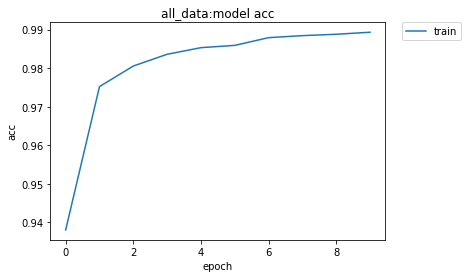

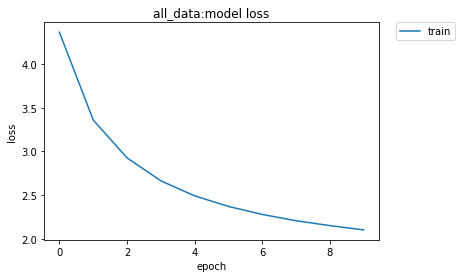

In [13]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
# データの水増しなし
if not "data-aug" in model_name:
    history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)
    
# データの水増しあり
else:
    datagen = ImageDataGenerator(
                rotation_range=10,  # -10° ~ 10°の範囲でランダムに回転
                zoom_range = 0.1, # 0.9 ~ 1.1 倍の範囲でランダムに拡大縮小
                width_shift_range=0.1,  # -0.1*width ~ 0.1*widthの範囲でランダムに左右平行移動
                height_shift_range=0.1)  # -0.1*height ~ 0.1*heightの範囲でランダムに上下平行移動

    datagen.fit(train)

    history = ResNetModel.fit_generator(datagen.flow(train,label, batch_size=batch_size), epochs = n_epoch,
                                        verbose = 1, shuffle=True, steps_per_epoch=train.shape[0] // batch_size)
    del datagen

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [14]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result1.csv", index = False)

# モデルの破棄
clear_session()
del ResNetModel, history
gc.collect()

521392

# 6. Ensemble model test

In [15]:
# 各バリデーションモデルの予測値の平均
test_predict = np.zeros((len(test), n_classes))
for model_file in glob.glob(model_dir+"/*"):
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    test_predict += loaded_model.predict(test)
    # モデルの破棄
    clear_session()
    del loaded_model
    gc.collect()

test_predict /= n_classes # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result2.csv", index = False)